In [1]:
#####HMC logistic regression####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy
import scipy.linalg
import scipy.stats as ss
from numpy.random import *
from scipy import optimize
from scipy.stats import norm
from scipy import sparse

In [2]:
####データの発生####
k = 20   #パラメータ数
N = 25000   #サンプル数

In [3]:
##説明変数の生成
k1 = 8; k2 = 7; k3 = 6
x1 = np.array(np.random.random(N*k1)).reshape((N, k1))
x2 = np.zeros((N, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    x2[:, j] = np.random.binomial(1, prob, N)
x3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), N)
x3 = np.delete(x3, np.argmin(np.sum(x3, axis=0)), axis=1)   #冗長な変数の削除
Data = np.concatenate((np.repeat(1, N)[:, np.newaxis], x1, x2, x3), axis=1)
k = Data.shape[1]

In [4]:
##応答変数の生成
rp = 0
while True:
    rp = rp + 1
    print(rp)
    
    #パラメータの生成
    beta0 = np.array(-0.4).reshape(1)
    beta1 = np.random.normal(0, 0.5, k-1)
    beta = np.hstack((beta0, beta1))
    betat = beta
    
    #ロジットと選択確率を設定
    logit = np.dot(Data, beta)
    Prob = np.exp(logit) / (1 + np.exp(logit))

    #ベルヌーイ分布から応答変数を生成
    y = np.random.binomial(1, Prob, N)
    np.mean(y)

    #break条件
    if((np.mean(y) > 0.2) & (np.mean(y) < 0.4)):
        break

np.mean(y)

1
2


0.23228

In [5]:
####ハミルトニアンモンテカルロ法でベイジアンロジスティック回帰モデルを推定####
##対数事後分布を計算する関数
def loglike(Data, y, beta, beta_prior, inv_Cov, k):
    #応答確率の設定
    mu = np.exp(np.dot(Data, beta))   #ロジットの指数
    Prob = mu / (1 + mu)   #確率の計算
    LLho = np.sum(y*np.log(Prob) + (1-y)*np.log(1-Prob))

    ##多変量正規分布の対数尤度
    er = beta - beta_prior
    log_prior = -1/2 * np.dot(np.dot(er.reshape(1, k), inv_Cov), er)

    #対数事後分布
    LL =  LLho + log_prior
    return LL

In [6]:
##対数事後分布の微分関数
def dloglike(beta, Data, y, beta_prior, inv_Cov, N, k):
    #応答確率の設定
    mu = np.exp(np.dot(Data, beta))   #ロジットの指数
    Prob = mu / (1 + mu)   #確率の計算

    #微分関数の設定
    er = beta - beta_prior
    dlogit = y.reshape(N, 1)*Data - Prob.reshape(N, 1)*Data   #ロジスティック回帰の対数尤度の微分関数
    dmvn = -np.dot(inv_Cov, er)   #多変量正規分布の対数事前分布の微分関数

    #勾配ベクトルの設定
    LLd = -(np.sum(dlogit, axis=0) + dmvn)
    return(LLd)

In [7]:
##リープフロッグ法を解く関数
def leapfrog(r, z, D, e, L): 
    def leapfrog_step(r, z, e):
        r2 = r - e * D(z, Data, y, beta_prior, inv_Cov, N, k) / 2
        z2 = z + e * r2
        r2 = r2 - e * D(z2, Data, y, beta_prior, inv_Cov, N, k) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [8]:
##アルゴリズムの設定
R = 2000
keep = 2
disp = 200
burnin = 500/keep
iter = 0
e = 0.01
L = 3

In [9]:
##事前分布の設定
beta_prior = np.repeat(0, k)
inv_Cov = np.linalg.inv(np.diag(np.repeat(100, k)))

In [10]:
##初期値の設定
beta = np.repeat(0, k)

In [11]:
##サンプリング結果の保存用配列
BETA = np.zeros((int(R/keep), k))
LL = np.zeros(int(R/keep))

In [12]:
####ハミルトニアンモンテカルロ法でパラメータをサンプリング####
for rp in range(R):
    ##HMCによりパラメータをサンプリング
    #HMCの新しいパラメータを生成
    rold = np.random.multivariate_normal(np.repeat(0, k), np.diag(np.repeat(1, k)), 1).reshape(-1)   #標準多変量正規分布からパラメータを生成
    betad = beta

    #リープフロッグ法による1ステップ移動
    res = leapfrog(rold, betad, dloglike, e, L)
    rnew = res[0]
    betan = res[1]

    #移動前と移動後のハミルトニアンを計算
    logln = loglike(Data, y, betan, beta_prior, inv_Cov, k)
    logld = loglike(Data, y, betad, beta_prior, inv_Cov, k)
    Hnew = -logln + np.sum(np.power(rnew, 2))/2
    Hold = -logld + np.sum(np.power(rold, 2))/2

    #HMC法によりパラメータを採択を決定
    alpha = np.min(np.array((1, np.exp(Hold - Hnew))))
    u = np.random.rand()   #一様乱数を発生

    #u < alphaなら新しいbetaを採択
    if u < alpha:
        beta = betan
        logl = logln
    else:
        beta = betad
        logl = logld

    ##サンプリング結果を保存
    if rp%keep==0:
        mkeep = int(rp/keep)
        BETA[mkeep, :] = beta
        LL[mkeep] = logl
        
    if rp%disp==0:
        #サンプリング結果を保存
        print(rp)
        print(np.round(np.vstack((beta, betat)), 3))
        print(alpha)
        print(logl)

C:\Users\sana\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp


0
[[-0.411 -0.301 -0.187 -0.272 -0.143 -0.219 -0.231 -0.423 -0.243  0.004
  -0.138  0.066 -0.228 -0.224 -0.051 -0.248 -0.333 -0.015 -0.028  0.079
  -0.119]
 [-0.4   -0.341  0.205 -0.122  0.685  0.211 -0.134 -1.239 -0.073  0.375
   0.076  0.547 -0.356 -0.332  0.188 -0.111 -1.288 -0.359 -0.462  0.085
  -0.697]]
1.0
[-13974.39193299]
200
[[-0.378 -0.351  0.191 -0.327  0.712  0.306 -0.128 -1.358 -0.024  0.496
   0.021  0.564 -0.372 -0.293  0.221 -0.133 -1.344 -0.394 -0.427  0.162
  -0.666]
 [-0.4   -0.341  0.205 -0.122  0.685  0.211 -0.134 -1.239 -0.073  0.375
   0.076  0.547 -0.356 -0.332  0.188 -0.111 -1.288 -0.359 -0.462  0.085
  -0.697]]
1.0
[-12415.98226172]
400
[[-0.318 -0.286  0.328 -0.188  0.662  0.19  -0.133 -1.265 -0.107  0.433
   0.024  0.592 -0.382 -0.353  0.237 -0.026 -1.413 -0.613 -0.724  0.08
  -0.848]
 [-0.4   -0.341  0.205 -0.122  0.685  0.211 -0.134 -1.239 -0.073  0.375
   0.076  0.547 -0.356 -0.332  0.188 -0.111 -1.288 -0.359 -0.462  0.085
  -0.697]]
0.9698399887028744
[

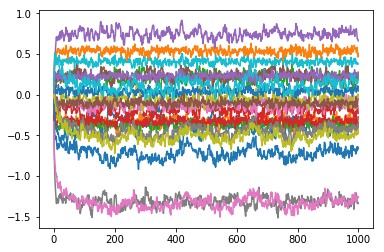

[[-0.383 -0.332  0.218 -0.186  0.748  0.226 -0.126 -1.315 -0.046  0.405
   0.045  0.536 -0.369 -0.328  0.229 -0.104 -1.332 -0.443 -0.516  0.117
  -0.724]
 [-0.4   -0.341  0.205 -0.122  0.685  0.211 -0.134 -1.239 -0.073  0.375
   0.076  0.547 -0.356 -0.332  0.188 -0.111 -1.288 -0.359 -0.462  0.085
  -0.697]]


array([0.086, 0.056, 0.057, 0.054, 0.05 , 0.057, 0.051, 0.054, 0.059,
       0.032, 0.032, 0.035, 0.036, 0.033, 0.032, 0.032, 0.066, 0.062,
       0.063, 0.072, 0.067])

In [13]:
####サンプリング結果の要約と可視化####
burnin = int(500/keep)
RS = int(R/keep)

##サンプリング結果の可視化
plt.plot(range(BETA.shape[0]), BETA)
plt.show()

##サンプリング結果の要約
print(np.round(np.array((np.mean(BETA[burnin:RS, :], axis=0), betat)), 3))   #パラメータの事後平均
np.round(np.std(BETA[burnin:RS, :], axis=0), 3)   #事後標準偏差